<div align="center">
    <h1>In The Name Of GOD</h1>
</div>

# RCV1 Dataset Visualization with Self Organizing Map

## Import Libraries

In [20]:
import itertools
import numpy as np
import pickle as pkl
from numpy.ma.core import ceil 
from numpy import linalg as LA
from joblib import Parallel, delayed, effective_n_jobs
from numpy import argmin, unravel_index, sqrt, ogrid, newaxis
from sklearn.metrics import DistanceMetric #distance calculation
from sklearn.utils import resample #resampling
from sklearn.preprocessing import MinMaxScaler, StandardScaler #normalization
from sklearn.pipeline import Pipeline #pipeline
from sklearn.model_selection import train_test_split #split data
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from tqdm import tqdm
import pprint

## Hyper parameters

In [21]:
NUM_SAMPLES = 10000 # number of samples to use
NUM_NEURONS = (5 * np.sqrt(NUM_SAMPLES)) #number of neurons in the SOM rectangular grid
GRID_SIZE = (ceil(np.sqrt(NUM_NEURONS)).astype(np.int32), ceil(np.sqrt(NUM_NEURONS)).astype(np.int32)) #size of the grid
NUM_ITERS = 3000 #number of iterations to run the SOM
BETA0 = 0.5 #initial learning rate
MU = 2 # initial mu for normal distribution
SIGMA0 = 11 # initial sigma for normal distribution
N_JOBS = effective_n_jobs() #number of jobs to run in parallel
MIN_BETA = 0.05 #minimum learning rate
MIN_SIGMA = 1 #minimum sigma for normal distribution

## Self Organizing Map (SOM) Implementation

### Helper Functions

In [43]:
def normal(x, mu, sigma): #calculate the normal distribution
    p = np.divide(1, np.sqrt(2 * np.pi * sigma**2))
    return np.multiply(p, np.exp(-0.5 / sigma**2 * (x - mu)**2))

def get_beta(epoch): #get the learning rate for the SOM
    # return max(BETA0 * np.exp(-5 * np.divide(epoch, NUM_ITERS)), MIN_BETA)
    return max(MIN_BETA, (BETA0 - MIN_BETA) * (1 - np.divide(epoch, NUM_ITERS)) + MIN_BETA)

def get_sigma(epoch): #get the sigma for the normal distribution
    # return max(SIGMA0 * np.exp(-5 * np.divide(epoch, NUM_ITERS)), MIN_SIGMA)
    return max(MIN_SIGMA, (SIGMA0 - MIN_SIGMA) * (1 - np.divide(epoch, NUM_ITERS)) + MIN_SIGMA)

def expand(x, shape): #expand the normal distribution to the grid size
    return np.tile(x[:, :, newaxis], (1, 1, shape))

def update_neurons(grid, best_match_idx, w, epoch): #update the neurons
    x0, y0 = best_match_idx #get the coordinates of the best match
    x, y = ogrid[0:GRID_SIZE[0], 0:GRID_SIZE[1]] #create a grid of coordinates
    distance_to_best_idx = sqrt(np.power((x - x0), 2) + np.power((y - y0), 2)) #calculate the distance between the neurons and the best match
    
    sigma = get_sigma(epoch) #get the sigma for the normal distribution
    # ns_values = normal(distance_to_best_idx, MU, sigma) #calculate the normal distribution
    ns_values = 1 / (distance_to_best_idx + 1)
    coefficient = expand(ns_values, grid.shape[-1]) #expand the normal distribution to the grid size
    
    # coefficient = np.tile(normal(ns_values, MU, get_sigma(epoch)), grid.shape) #calculate the coefficient for the neurons
    distances = coefficient * (grid - w) #calculate the distance between the neurons and the input
    
    grid = grid + get_beta(epoch) * distances #update the neurons

def find_winning_neuron(grid, x): #find the winning neuron
    distances = LA.norm(grid - x, axis=-1) #calculate the distance between the neurons and the input
    return unravel_index(argmin(distances), grid.shape[0:-1])

def get_pipeline(scaler=StandardScaler()): #create a pipeline for the data
    return Pipeline([
        ('scaler', scaler)
    ])

def get_best_matching_units(grid, X: list): #get the best matching units for the input list
    return Parallel(n_jobs=N_JOBS)(delayed(find_winning_neuron)(grid, X[i]) for i in tqdm(range(len(X)), desc='Finding BMUs'))

### Import Dataset

In [23]:
from sklearn.datasets import fetch_rcv1 #fetch the RCV1 dataset
rcv1 = fetch_rcv1() 

X, Y = rcv1.data, rcv1.target

In [24]:
pprint.pprint(f'X.shape: {X.shape}')
pprint.pprint(f'Y.shape: {Y.shape}')
pprint.pprint(f'num_samples: {X.shape[0]}')
pprint.pprint(f'num_features: {X.shape[1]}')
pprint.pprint(f'num_classes: {Y.shape[1]}')

'X.shape: (804414, 47236)'
'Y.shape: (804414, 103)'
'num_samples: 804414'
'num_features: 47236'
'num_classes: 103'


### Data Preprocessing

In [25]:
X_resampled, Y_resampled = resample(X, Y, n_samples=NUM_SAMPLES, random_state=42) #resample data

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42) #split data into training and testing sets

pipeline = get_pipeline()
X_train_pipelined = pipeline.fit_transform(X_train.toarray()) #scale data
X_test_pipelined = pipeline.transform(X_test.toarray()) #scale data

### Self Organizing Map (SOM) Initialization

In [32]:
grid = np.random.rand(*GRID_SIZE, X_train_pipelined.shape[1]) #initialize the grid with random values

pprint.pprint(f'Grid rectangle is of width and height of {GRID_SIZE}')
pprint.pprint(f'Neuron grid is of shape {grid.shape}')

'Grid rectangle is of width and height of (23, 23)'
'Neuron grid is of shape (23, 23, 47236)'


### Training Self Organizing Map (SOM)

In [44]:
for epoch in tqdm(range(NUM_ITERS), desc='Epochs', leave=True): #train the SOM
    rnd_idx = np.random.randint(0, X_train_pipelined.shape[0]) #get a random index
    x = X_train_pipelined[rnd_idx] #get the data
    best_match_idx = find_winning_neuron(grid, x) #find the index of the neuron with the smallest distance to the input
    update_neurons(grid, best_match_idx, x, epoch) #update the neurons

Epochs: 100%|██████████| 3000/3000 [10:17<00:00,  4.86it/s]


### Saving weights of SOM

In [46]:
with open('model/som.pkl', 'wb') as f: #save the SOM
    pkl.dump(grid, f)
    pprint.pprint(f'SOM saved to model/som.pkl')

'SOM saved to model/som.pkl'


### Loading weights of SOM

In [ ]:
with open('model/som.pkl', 'rb') as f: #load the SOM
    grid = pkl.load(f)
    pprint.pprint(f'Grid has been loaded from model/som.pkl')

'Grid has been loaded from model/som.pkl'


## Visualizing SOM

### Helper Functions

In [47]:
dx = [0, 0, 1, -1] #neighborhood offsets
dy = [1, -1, 0, 0] #neighborhood offsets

def calc_u_matrix(grid): #calculate the U matrix
    u_matrix = np.zeros(GRID_SIZE) #initialize the U matrix
    for pos in itertools.product(range(grid.shape[0]), range(grid.shape[1])):
        num_neighbors = 0
        for i in range(len(dx)):
            x = pos[0] + dx[i]
            y = pos[1] + dy[i]
            if x >= 0 and x < grid.shape[0] and y >= 0 and y < grid.shape[1]:
                u_matrix[pos] += LA.norm(grid[pos] - grid[x, y], axis=-1)
                num_neighbors += 1
        u_matrix[pos] /= num_neighbors
    return u_matrix

### Plotting U-Matrix

In [41]:
u_matrix = calc_u_matrix(grid) #calculate the U matrix

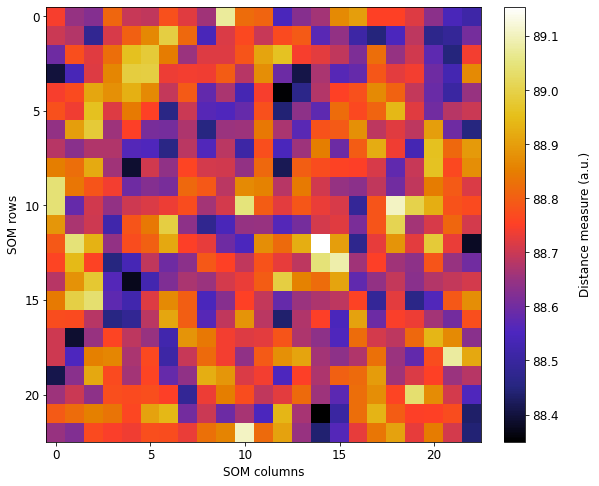

In [42]:
cmap="CMRmap"
fontsize=12
_, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(u_matrix, cmap=cmap)

# ticks and labels
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
ax.set_ylabel("SOM rows", fontsize=fontsize)
ax.set_xlabel("SOM columns", fontsize=fontsize)

# colorbar
cbar = plt.colorbar(img, ax=ax, fraction=0.04, pad=0.04)
cbar.ax.set_ylabel(
    "Distance measure (a.u.)", rotation=90, fontsize=fontsize, labelpad=20
)
cbar.ax.tick_params(labelsize=fontsize)

### calculating best matching units for each test data point

the performance of getting the best matching unit is very good compared to the performance of the training part because of the **parallelization** of the algorithm.

In [49]:
bmus = get_best_matching_units(grid, X_test_pipelined) 

Finding BMUs: 100%|██████████| 2000/2000 [00:39<00:00, 50.41it/s]
